In [3]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [13]:
data_btc = pd.read_csv("/Users/karimmeguenni-tani/Bot project trading/Cryptobot/DataBase/1h/BTC-USDT-USDT.csv")
data_btc.index = pd.to_datetime(data_btc['date'], unit='ms')
data_btc = data_btc.drop('date', axis=1)

In [14]:

data= data_btc.copy()
# Load historical data
display(data)

# Function to calculate moving averages
def calculate_ma(data):
    data['ma_short'] = data['close'].rolling(window=50).mean()
    data['ma_long'] = data['close'].rolling(window=200).mean()
    return data

def strategy(row):
    if row['ma_short'] > row['ma_long']:
        return 'buy'
    elif row['ma_short'] < row['ma_long']:
        return 'sell'
    else:
        return 'hold'
# Initial wallet and parameters

def set_starting_trading():
    wallet_start = {"usdt": 1000, "coin": 0}
    wallet = wallet_start.copy()

    parameters = {
        "wallet": 1000,
        "usdt": 1000,
        "coin": 0,
        "taker_fee": 0.0007,
        "maker_fee": 0.0002,
        "balance_percentage_usdt": 0.1,
        "balance_percentage_coin": 1,
        "symbol": "BTC/USDT",
        "num_trades": 0,
        "trade_status": "None",
    }
    parameters_records = pd.DataFrame(columns=list(parameters.keys()))

    return wallet_start, wallet, parameters, parameters_records

# Function to calculate wallet value
def calculate_value_wallet(wallet, row):
    return wallet["usdt"] + wallet["coin"] * row["close"]

# Function to execute a trade
def execute_trade(wallet, row, trade_type, parameters):
    if trade_type == "Buy" and wallet["usdt"] > 0:
        # Calculate amount of coin to buy
        amount_coin = (wallet["usdt"] * parameters["balance_percentage_usdt"]) / row["close"]
        wallet["coin"] += amount_coin * (1 - parameters["taker_fee"])
        wallet["usdt"] -= wallet["usdt"] * parameters["balance_percentage_usdt"]
        trade_status = "Buy"
    elif trade_type == "Sell" and wallet["coin"] > 0:
        # Calculate amount of coin to sell
        amount_usdt = wallet["coin"] * row["close"] * parameters["balance_percentage_coin"]
        wallet["usdt"] += amount_usdt * (1 - parameters["taker_fee"])
        wallet["coin"] -= wallet["coin"] * parameters["balance_percentage_coin"]
        trade_status = "Sell"
    else:
        trade_status = "Hold"
    
    return wallet, trade_status

# Simulation loop
def backtesting(data, wallet_start, parameters,strategy):
    wallet_values = []
    parameters_records = pd.DataFrame(columns=list(parameters.keys()))

    for idx, row in tqdm(data.iterrows(), total=len(data), desc="Simulating"):
        current_wallet_value = calculate_value_wallet(wallet_start, row)
        parameters["wallet"] = current_wallet_value
        wallet_values.append(current_wallet_value)

        # Simple trading strategy: buy if price is above MA, sell if below
        if strategy(row) == "buy":
            wallet_start, trade_status = execute_trade(wallet_start, row, "Buy", parameters)
        elif strategy(row) == "sell":
            wallet_start, trade_status = execute_trade(wallet_start, row, "Sell", parameters)
        else:
            trade_status = "Hold"

        # Update parameters and record trade
        parameters["num_trades"] += 1
        parameters["trade_status"] = trade_status
        parameters_records = pd.concat([parameters_records, pd.DataFrame([parameters])], ignore_index=True)

    # Evaluate performance
    final_wallet_value = calculate_value_wallet(wallet_start, data.iloc[-1])
    print(f"Final wallet value: {final_wallet_value}")
    print(f"Number of trades: {parameters['num_trades']}")

    # Plot wallet value over time
    data['wallet_value'] = wallet_values

    return data,wallet_values, parameters_records, final_wallet_value


# Créer la colonne close_adjusted
def ajusting_close(data, wallet_values):
    data['close_adjusted'] = data['close'] / data['close'].iloc[0] * wallet_values[0]
    return data


def plot_wallet_value_and_close(data):
    # Afficher les courbes wallet_value et close sur le même graphe
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=data.index, y='wallet_value', data=data)
    sns.lineplot(x=data.index, y='close_adjusted', data=data)

    plt.title('Valeur du portefeuille et prix ajusté du BTC')
    plt.xlabel('Temps')
    plt.ylabel('Valeur')
    plt.legend(['Valeur Portefeuille', 'Close ajusté'])
    plt.figure(figsize=(12, 6))
    plt.title('BTC Price')
    sns.lineplot(x=data.index, y='close', data=data)
    plt.show()



,open,high,low,close,volume
date,,,,,
2019-07-10 11:00:00,13073.5,13075.5,13044.5,13064.5,4.8952
2019-07-10 12:00:00,13064.5,13064.5,12900.5,13029.0,684.5329
2019-07-10 13:00:00,13029.0,13127.5,12996.5,13039.5,812.2584
2019-07-10 14:00:00,13039.5,13065.5,12549.5,12549.5,679.7040
2019-07-10 15:00:00,12549.5,12552.0,12121.0,12362.0,715.6550
...,...,...,...,...,...
2024-04-19 23:00:00,63964.2,64095.3,62890.7,63771.2,14875.2400
2024-04-20 00:00:00,63771.2,64216.4,63365.5,63401.3,8151.1100
2024-04-20 01:00:00,63401.3,63741.9,63031.2,63606.8,7683.9050


Simulating:   0%|          | 0/41897 [00:00<?, ?it/s]

/var/folders/nj/x9ql9239587bdd83s2gscjvm0000gn/T/ipykernel_72645/307771615.py:84: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parameters_records = pd.concat([parameters_records, pd.DataFrame([parameters])], ignore_index=True)
Simulating: 100%|██████████| 41897/41897 [00:35<00:00, 1183.44it/s]


Final wallet value: 2501.0811968576563
Number of trades: 41897


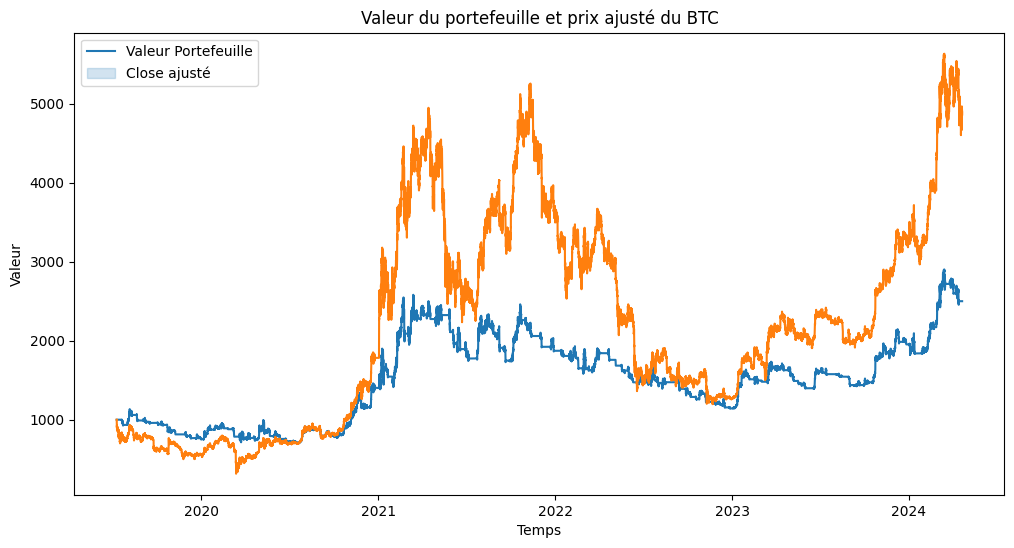

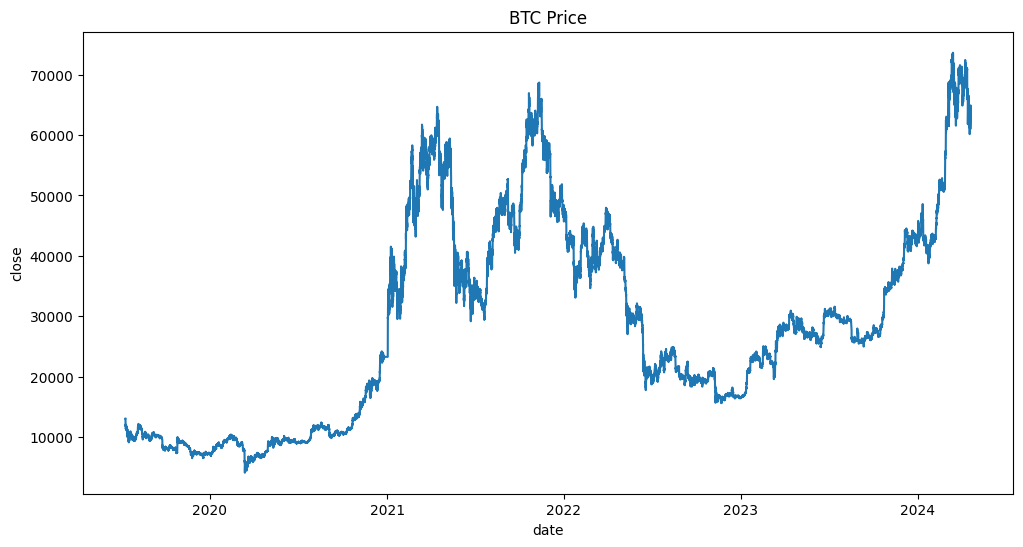

In [15]:
data = calculate_ma(data)

wallet_start, wallet, parameters, parameters_records= set_starting_trading()

data,wallet_values, parameters_records, final_wallet_value = backtesting(data, wallet_start, parameters,strategy)

data = ajusting_close(data, wallet_values)

plot_wallet_value_and_close(data)